In [1]:
#import standard data analysis libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
from functions import *

This part of the code contains the functions used later on

In [5]:
#main function dictating which functions to call for calculating player stats
def add_to_df_players(df_players, df_savant, at_bat_ids):
    """
    Enhances the df_players DataFrame by computing and adding various performance statistics 
    based on player event data from df_savant and at_bat_ids.

    This function:
    - Filters out players without an MLB ID.
    - Computes the number of years since a player’s MLB debut.
    - Aggregates plate appearance (PA) and batters faced (BF) counts.
    - Tracks fielding appearances at different positions.
    - Counts the occurrences of various play events (e.g., hits, strikeouts, walks).
    - Computes key batting statistics like batting average, slugging, and on-base percentage.

    Parameters:
    -----------
    df_players : pandas.DataFrame
        DataFrame containing player-level information, including player IDs and debut years.
    df_savant : pandas.DataFrame
        Baseball Savant event-level data, which includes play-by-play information.

    Returns:
    --------
    pandas.DataFrame
        Updated df_players with additional columns
    """
    
    #remove players without an mlb Id
    df_players = df_players[df_players['player_mlb_id'].notna()]

    #calculate years since a player debuted
    df_players['years_after_debut'] = df_players['year'] - df_players['debut'].str[-4:].astype(int)

    #get the counts for the main dataframe
    df_players = compute_player_pa_and_bf(df_players, at_bat_ids, df_savant)

    #calculate where a player played in the field
    df_players = get_fielding_counts(df_players, df_savant)

    #count how many of each stat a player had on the year
    df_players = calculate_all_play_event_counts(df_players,df_savant)

    #calculate average lineup position
    df_players = calculate_lineup_position(df_players, df_savant)
    
    #calculate general batting stats
    df_players = calculate_batting_stats(df_players, df_savant)

    #innings pitched calculation
    df_players = calculate_innings_pitched(df_players, df_savant)

    #average fastball velocity
    df_players = fastball_velocity(df_players, df_savant)
    
    #calculate pitching stats
    df_players = calculate_pitching_stats(df_players)

    #add average batters faced per outing for pitchers
    df_players = calculate_batters_faced_in_game(df_players,df_savant)

    #find inzone + chase rate
    df_players = calculate_zone_chase_pct(df_players, df_savant)
    
    #calculate rbis
    df_players = calculate_rbis(df_players,df_savant)

    #calculate average expected batting avg for batters and pitchers
    df_players = calculate_average_exp_ba(df_players,df_savant,'batter')
    df_players = calculate_average_exp_ba(df_players,df_savant,'pitcher')

    #look at expected wOBA and .avg for hits to get a better idea

    #get player position estimates
    df_players = primary_position(df_players)

    #get percentage of times a pitcher started
    df_players = add_sp_percentage(df_players, df_savant)
    
    #get player age
    df_players['age'] = df_players['year'] - df_players['birthYear']
    
    #years from 26-28 peak age performance (https://tht.fangraphs.com/how-do-baseball-players-age-part-1/)
    df_players['years_before_26'] = (26 - df_players['age']).clip(lower=0)
    df_players['years_after_28'] = (df_players['age'] - 28).clip(lower=0)

    return df_players

Past the functions

In [7]:
#read the csvs as dataframes
df_savant_raw = pd.read_csv('savant_data_2021_2023.csv')
df_people = pd.read_csv('lahman_people.csv')

In [8]:
#create dataframe for player season info
df_players = pd.concat([df_people.assign(year=i) for i in range(2021, 2024)], ignore_index=True)

In [9]:
#clean Savant data
df_savant, at_bat_ids = clean_savant_data(df_savant_raw)

In [10]:
#add columns to df_players based on the Savant data
df_players_full = add_to_df_players(df_players, df_savant, at_bat_ids)

In [11]:
# #get savant data for batting splits
# df_savant_r = df_savant_raw[df_savant_raw['p_throws'] == 'R']
# df_savant_l = df_savant_raw[df_savant_raw['p_throws'] == 'L']

# #make df_players for each batting split
# df_players_r = add_to_df_players(df_players, df_savant_r)
# df_players_l = add_to_df_players(df_players, df_savant_l)

In [12]:
# #if needed later
# df_players_full['had_pa'] = df_players_full['total_pa'] > 0
# df_players_full['had_bf'] = df_players_full['total_bf'] > 0
# df_players_full['had_pa_or_bf'] = (df_players_full['had_pa'] + df_players_full['had_bf']) > 0

In [13]:
#export csv for use in other .ipynb
df_players_full.to_csv('df_players.csv')
# df_players_r.to_csv('df_players_right.csv')
# df_players_l.to_csv('df_players_left.csv')

In [14]:
for i in df_players_full.columns:
    print(i)

player_mlb_id
playerID_LAHMAN
birthYear
birthMonth
birthDay
birthCountry
weight
height
bats
throws
debut
birthDate
year
years_after_debut
total_pa
total_bf
base_ended_inn
field_p
field_c
field_1b
field_2b
field_3b
field_ss
field_lf
field_cf
field_rf
batter_strikeout
pitcher_strikeout
batter_caught_stealing_3b
pitcher_caught_stealing_3b
batter_field_out
pitcher_field_out
batter_walk
pitcher_walk
batter_force_out
pitcher_force_out
batter_sac_fly
pitcher_sac_fly
batter_single
pitcher_single
batter_hit_by_pitch
pitcher_hit_by_pitch
batter_double
pitcher_double
batter_grounded_into_double_play
pitcher_grounded_into_double_play
batter_sac_bunt
pitcher_sac_bunt
batter_home_run
pitcher_home_run
batter_fielders_choice
pitcher_fielders_choice
batter_field_error
pitcher_field_error
batter_other_out
pitcher_other_out
batter_caught_stealing_2b
pitcher_caught_stealing_2b
batter_triple
pitcher_triple
batter_strikeout_double_play
pitcher_strikeout_double_play
batter_fielders_choice_out
pitcher_fielder

<Axes: xlabel='total_pa', ylabel='Count'>

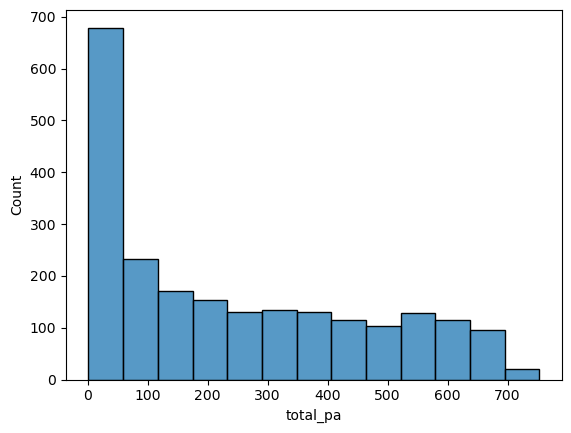

In [15]:
#plot of total plate appearances (min 1). Note this includes pitchers
df_players_with_pa = df_players_full[df_players_full['total_pa'] > 0] 
sns.histplot(df_players_with_pa['total_pa'])

<Axes: xlabel='total_bf', ylabel='Count'>

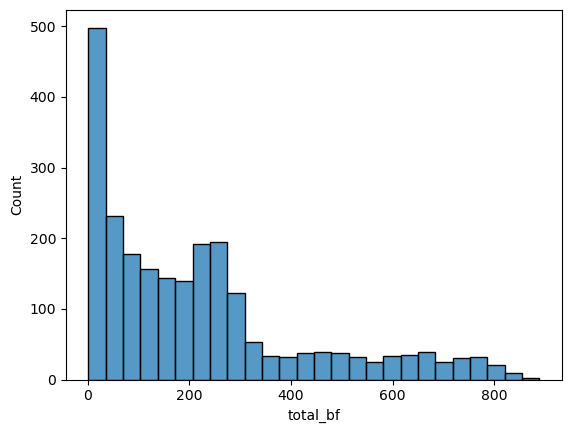

In [16]:
#plot of total batters faced (min 1). Note this includes position players
df_players_with_pa = df_players_full[df_players_full['total_bf'] > 0] 
sns.histplot(df_players_with_pa['total_bf'])

In [17]:
def linear_regression_scatter(df, x, y, min_x=False, min_y=False):
    """
    This function filters out missing values and optionally removes entries that do not meet 
    specified minimum thresholds for the x and y variables. It then fits a simple linear 
    regression model, plots the data points, and overlays the regression line.

    Parameters:
    -----------
    df : pandas.DataFrame
        The dataset containing the variables to be plotted.
    x : str
        The column name representing the independent variable.
    y : str
        The column name representing the dependent variable.
    min_x : float or bool, optional (default=False)
        The minimum threshold for filtering x values. Entries with x < min_x will be removed.
    min_y : float or bool, optional (default=False)
        The minimum threshold for filtering y values. Entries with y < min_y will be removed.

    Returns: None
    """
    
    #filter entries to where columns aren't null
    df = df[df[x].notnull() & df[y].notnull()]

    #filter out player who do not meet the min
    if min_x != False:
        df = df[df[x] >= min_x]
    
    if min_y != False:
        df = df[df[y] >= min_y]
    
    #get passed columns 
    x_vals = df[x]
    y_vals = df[y]
    
    #perform linear regression
    slope, intercept, r, p, std_err = stats.linregress(x_vals, y_vals)
    
    #define regression function
    def myfunc(x_vals):
        return slope * x_vals + intercept
    
    #generate regression line values
    mymodel = list(map(myfunc, x_vals))
    
    #create scatter plot with regression line
    plt.figure(figsize=(10, 6))  # Increase figure size for better readability
    sns.set_theme(style="whitegrid")  # Use a clean theme
    
    #scatter plot
    sns.scatterplot(x=x_vals, y=y_vals, color="blue", alpha=0.6, s=60, label="Player Data")
    
    #regression line
    plt.plot(x_vals, mymodel, color="red", linewidth=2, label=f"Regression Line (a: {slope:.2f}, b: {intercept:.2f}, R²={r**2:.2f})")
    
    #add text and plot
    plt.title(f"Relationship Between {x} and {y}", fontsize=16)
    plt.xlabel(f"{x}", fontsize=14)
    plt.ylabel(f"{y}", fontsize=14)
    plt.legend(fontsize=12)
    plt.tight_layout()
    plt.show()

In [18]:
df_players_full.head()

,player_mlb_id,playerID_LAHMAN,birthYear,birthMonth,birthDay,birthCountry,weight,height,bats,throws,...,avg_bf_per_outing,zone_chase_pct,total_runs,batter_avg_exp_ba,pitcher_avg_exp_ba,primary_position,sp_pct,age,years_before_26,years_after_28
0,0629cd765e77d52b8a43cb56621c82d949e50323,146ae8ecba2a3af909b0814df68b5d49583f5ec5,1985,12,17,D.R.,235,74,L,L,...,3.950617,0.588629,NaN,NaN,0.322862,p,0.000000,36,0,8
1,33438ca2fdf93ff73b2e1bcc5da3058a04cf1661,543bb62c4bdd4911df4bd1a2313a975300d04ee6,1995,9,20,USA,220,74,R,R,...,7.341463,0.562500,0.0,0.202500,0.318492,p,22.222222,26,0,0
2,f79cf1f3d100e5f34d86ce2cd4c8c35ca3daee77,e195c4bc19cb6a08203e3c9e361677b73dbfdc03,2000,10,3,USA,185,74,L,R,...,NaN,NaN,NaN,NaN,NaN,ss,NaN,21,5,0
3,3d65b1ac983ce90ff1f21f56b627883affc7dad1,0029980d1ad27d254bc1f60e31a32fcdd150ea37,1997,4,22,D.R.,225,73,R,R,...,3.453416,0.574746,NaN,NaN,0.338260,p,0.000000,24,2,0
4,80f3a94c7bf1ed6397017744dbb75ff931902e2d,d851612368c1e9612c0c2a444018af96a59bf0b9,1987,1,29,Cuba,235,75,R,R,...,NaN,NaN,120.0,0.343302,NaN,1b,NaN,34,0,6


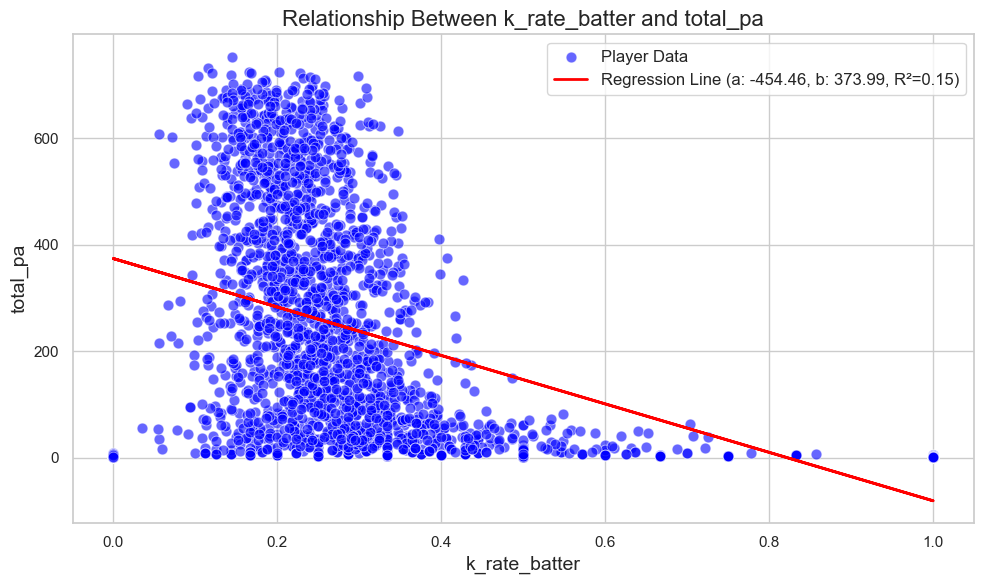

In [19]:
linear_regression_scatter(df_players_full,'k_rate_batter','total_pa')

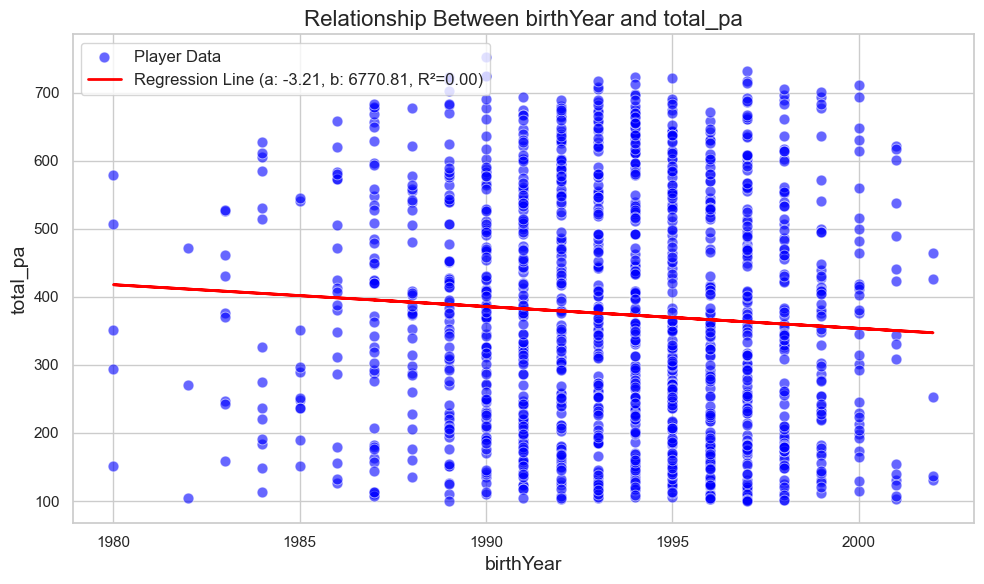

In [20]:
linear_regression_scatter(df_players_full,'birthYear','total_pa', min_y=100)

In [21]:
#full list of all columns in df_players
for i in df_players_full.columns:
    print(i + ',')

player_mlb_id,
playerID_LAHMAN,
birthYear,
birthMonth,
birthDay,
birthCountry,
weight,
height,
bats,
throws,
debut,
birthDate,
year,
years_after_debut,
total_pa,
total_bf,
base_ended_inn,
field_p,
field_c,
field_1b,
field_2b,
field_3b,
field_ss,
field_lf,
field_cf,
field_rf,
batter_strikeout,
pitcher_strikeout,
batter_caught_stealing_3b,
pitcher_caught_stealing_3b,
batter_field_out,
pitcher_field_out,
batter_walk,
pitcher_walk,
batter_force_out,
pitcher_force_out,
batter_sac_fly,
pitcher_sac_fly,
batter_single,
pitcher_single,
batter_hit_by_pitch,
pitcher_hit_by_pitch,
batter_double,
pitcher_double,
batter_grounded_into_double_play,
pitcher_grounded_into_double_play,
batter_sac_bunt,
pitcher_sac_bunt,
batter_home_run,
pitcher_home_run,
batter_fielders_choice,
pitcher_fielders_choice,
batter_field_error,
pitcher_field_error,
batter_other_out,
pitcher_other_out,
batter_caught_stealing_2b,
pitcher_caught_stealing_2b,
batter_triple,
pitcher_triple,
batter_strikeout_double_play,
pitcher_str

IN PROGRESS: start looking at pitching information

In [23]:
#see pitch run (is this right? Why do sliders have the least movement?)
counts = df_savant_raw.groupby(['pitcher','year','pitch_type'])[['release_speed']].count().reset_index()
df_players_full_merge = df_players_full.merge(counts, left_on=['player_mlb_id', 'year'], right_on=['pitcher', 'year'], how='left')

In [24]:
#get fastball velocity

In [25]:
df_players_full_merge.head()

,player_mlb_id,playerID_LAHMAN,birthYear,birthMonth,birthDay,birthCountry,weight,height,bats,throws,...,batter_avg_exp_ba,pitcher_avg_exp_ba,primary_position,sp_pct,age,years_before_26,years_after_28,pitcher,pitch_type,release_speed
0,0629cd765e77d52b8a43cb56621c82d949e50323,146ae8ecba2a3af909b0814df68b5d49583f5ec5,1985,12,17,D.R.,235,74,L,L,...,NaN,0.322862,p,0.0,36,0,8,0629cd765e77d52b8a43cb56621c82d949e50323,CH,47.0
1,0629cd765e77d52b8a43cb56621c82d949e50323,146ae8ecba2a3af909b0814df68b5d49583f5ec5,1985,12,17,D.R.,235,74,L,L,...,NaN,0.322862,p,0.0,36,0,8,0629cd765e77d52b8a43cb56621c82d949e50323,FC,16.0
2,0629cd765e77d52b8a43cb56621c82d949e50323,146ae8ecba2a3af909b0814df68b5d49583f5ec5,1985,12,17,D.R.,235,74,L,L,...,NaN,0.322862,p,0.0,36,0,8,0629cd765e77d52b8a43cb56621c82d949e50323,FF,19.0
3,0629cd765e77d52b8a43cb56621c82d949e50323,146ae8ecba2a3af909b0814df68b5d49583f5ec5,1985,12,17,D.R.,235,74,L,L,...,NaN,0.322862,p,0.0,36,0,8,0629cd765e77d52b8a43cb56621c82d949e50323,KC,78.0
4,0629cd765e77d52b8a43cb56621c82d949e50323,146ae8ecba2a3af909b0814df68b5d49583f5ec5,1985,12,17,D.R.,235,74,L,L,...,NaN,0.322862,p,0.0,36,0,8,0629cd765e77d52b8a43cb56621c82d949e50323,SI,139.0


In [26]:
all_pitch_types = df_savant_raw['pitch_type'].dropna().unique()

In [27]:
#for pitch in all_pitch_types:
    

In [28]:
#find percent of each pitch thrown by each player
#get average x and z run of each pitch